In [1]:
import sys, os, datetime
sys.path.append("../../../")

from utils.contract_utils import init_contract
from utils.network_utils import configure_network_and_connect

import brownie

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
configure_network_and_connect(
    node_provider_https=f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}",
    network_name='mainnet'
)

In [4]:
tricrypto2_contract_addr = "0xD51a44d3FaE010294C616388b506AcdA1bfAAE46"
tricrypto2_contract = init_contract(tricrypto2_contract_addr)
tricrypto2_contract

<Vyper_contract Contract '0xD51a44d3FaE010294C616388b506AcdA1bfAAE46'>

In [5]:
tricrypto2_contract.price_oracle(0) * 1e-18

65585.323207767

In [6]:
tricrypto2_lp_token_price_contract_address = "0xE8b2989276E2Ca8FDEA2268E3551b2b4B2418950"
contract_genesis = 12821148
tricrypto2_lp_token_price_contract = init_contract(tricrypto2_lp_token_price_contract_address)
tricrypto2_lp_token_price_contract

<Vyper_contract Contract '0xE8b2989276E2Ca8FDEA2268E3551b2b4B2418950'>

In [7]:
tricrypto2_lp_token_price_contract.lp_price() * 1e-18

2025.769292505115

In [8]:
def get_lp_price_from_block(
    block_number_start: int,
    lp_price_contract: brownie.Contract,
    lp_contract: brownie.Contract,
    block_steps: int = 10000
) -> pd.DataFrame:

    current_block = brownie.web3.eth.block_number
    blocks_to_calculate = list(range(block_number_start, current_block, block_steps))
    blocks_to_calculate.append(current_block)

    data = {
        'timestamp': [],
        'block_number': [],
        'lp_token_price': [],
        'btc_price': [],
        'eth_price': [],
    }

    for block_number in blocks_to_calculate:

        block_details = brownie.web3.eth.get_block(block_number)
        block_time = datetime.datetime.fromtimestamp(block_details['timestamp'])
        btc_price = lp_contract.price_oracle(0, block_identifier=block_number) * 1e-18
        eth_price = lp_contract.price_oracle(1, block_identifier=block_number) * 1e-18

        try:
            lp_token_price = lp_price_contract.lp_price(block_identifier=block_number)
        except ValueError:  # lp_price contract doesn't exist yet smh
            lp_token_price = 0


        data['timestamp'].append(block_time)
        data['block_number'].append(block_number)
        data['lp_token_price'].append(lp_token_price)
        data['btc_price'].append(btc_price)
        data['eth_price'].append(eth_price)

    df_data = pd.DataFrame(data)

    return df_data.set_index('timestamp')

In [33]:
block_start = brownie.web3.eth.block_number - 10000
df_prices = get_lp_price_from_block(
    block_number_start=block_start,
    lp_price_contract=tricrypto2_lp_token_price_contract,
    lp_contract=tricrypto2_contract,
    block_steps=100
)
df_prices

,block_number,lp_token_price,btc_price,eth_price
timestamp,,,,
2021-11-09 09:31:14,13581138,2073896451228726066684,67880.123800,4799.065528
2021-11-09 09:58:35,13581238,2073896451228726066684,67880.123800,4799.065528
2021-11-09 10:19:17,13581338,2073896451228726066684,67880.123800,4799.065528
2021-11-09 10:44:03,13581438,2071898435231913289340,67863.613771,4786.377241
2021-11-09 11:06:57,13581538,2071898435231913289340,67863.613771,4786.377241
...,...,...,...,...
2021-11-10 21:52:00,13590738,2047265700361951308368,66730.441747,4695.649706
2021-11-10 22:13:07,13590838,2034376499104043656035,66064.023595,4653.987439
2021-11-10 22:39:06,13590938,2013691985818806287628,64962.276600,4589.895244


Calculate Index Price:

In [54]:
seed_num_dollars = 100
seed_num_eth = 100/df_prices.eth_price.iloc[0]
seed_num_btc = 100/df_prices.btc_price.iloc[0]

df_prices['index_price'] = 0
for idx, row in df_prices.iterrows():

    df_prices.loc[idx, 'index_price'] = (
            seed_num_dollars + seed_num_eth*row.eth_price + seed_num_btc*row.btc_price
    )

df_prices

,block_number,lp_token_price,btc_price,eth_price,lp_token_price_diff,btc_price_diff,eth_price_diff,lp_token_price_diff_perc,btc_price_diff_perc,eth_price_diff_perc,index_price
timestamp,,,,,,,,,,,
2021-11-09 09:31:14,13581138,2073.896451,67880.123800,4799.065528,NaN,NaN,NaN,NaN,NaN,NaN,300.000000
2021-11-09 09:58:35,13581238,2073.896451,67880.123800,4799.065528,0.0,0.000000,0.000000,0.0,0.000000,0.000000,300.000000
2021-11-09 10:19:17,13581338,2073.896451,67880.123800,4799.065528,0.0,0.000000,0.000000,0.0,0.000000,0.000000,300.000000
2021-11-09 10:44:03,13581438,2071.898435,67863.613771,4786.377241,-1.998016,-16.510029,-12.688288,-0.096434,-0.024328,-0.265092,299.711287
2021-11-09 11:06:57,13581538,2071.898435,67863.613771,4786.377241,0.0,0.000000,0.000000,0.0,0.000000,0.000000,299.711287
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10 21:52:00,13590738,2047.2657,66730.441747,4695.649706,-2.622075,-58.334352,-13.965587,-0.128077,-0.087418,-0.297415,296.151389
2021-11-10 22:13:07,13590838,2034.376499,66064.023595,4653.987439,-12.889201,-666.418152,-41.662267,-0.63357,-1.008746,-0.895195,294.301499
2021-11-10 22:39:06,13590938,2013.691986,64962.276600,4589.895244,-20.684513,-1101.746994,-64.092196,-1.027194,-1.695980,-1.396376,291.342908


In [34]:
df_prices.lp_token_price *= 1e-18
df_prices

,block_number,lp_token_price,btc_price,eth_price
timestamp,,,,
2021-11-09 09:31:14,13581138,2073.896451,67880.123800,4799.065528
2021-11-09 09:58:35,13581238,2073.896451,67880.123800,4799.065528
2021-11-09 10:19:17,13581338,2073.896451,67880.123800,4799.065528
2021-11-09 10:44:03,13581438,2071.898435,67863.613771,4786.377241
2021-11-09 11:06:57,13581538,2071.898435,67863.613771,4786.377241
...,...,...,...,...
2021-11-10 21:52:00,13590738,2047.2657,66730.441747,4695.649706
2021-11-10 22:13:07,13590838,2034.376499,66064.023595,4653.987439
2021-11-10 22:39:06,13590938,2013.691986,64962.276600,4589.895244


In [55]:
df_prices['lp_token_price_diff'] = df_prices.lp_token_price.diff()
df_prices['btc_price_diff'] = df_prices.btc_price.diff()
df_prices['eth_price_diff'] = df_prices.eth_price.diff()
df_prices['index_price_diff'] = df_prices.index_price.diff()

df_prices

,block_number,lp_token_price,btc_price,eth_price,lp_token_price_diff,btc_price_diff,eth_price_diff,lp_token_price_diff_perc,btc_price_diff_perc,eth_price_diff_perc,index_price,index_price_diff
timestamp,,,,,,,,,,,,
2021-11-09 09:31:14,13581138,2073.896451,67880.123800,4799.065528,NaN,NaN,NaN,NaN,NaN,NaN,300.000000,NaN
2021-11-09 09:58:35,13581238,2073.896451,67880.123800,4799.065528,0.0,0.000000,0.000000,0.0,0.000000,0.000000,300.000000,0.000000
2021-11-09 10:19:17,13581338,2073.896451,67880.123800,4799.065528,0.0,0.000000,0.000000,0.0,0.000000,0.000000,300.000000,0.000000
2021-11-09 10:44:03,13581438,2071.898435,67863.613771,4786.377241,-1.998016,-16.510029,-12.688288,-0.096434,-0.024328,-0.265092,299.711287,-0.288713
2021-11-09 11:06:57,13581538,2071.898435,67863.613771,4786.377241,0.0,0.000000,0.000000,0.0,0.000000,0.000000,299.711287,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10 21:52:00,13590738,2047.2657,66730.441747,4695.649706,-2.622075,-58.334352,-13.965587,-0.128077,-0.087418,-0.297415,296.151389,-0.376944
2021-11-10 22:13:07,13590838,2034.376499,66064.023595,4653.987439,-12.889201,-666.418152,-41.662267,-0.63357,-1.008746,-0.895195,294.301499,-1.849890
2021-11-10 22:39:06,13590938,2013.691986,64962.276600,4589.895244,-20.684513,-1101.746994,-64.092196,-1.027194,-1.695980,-1.396376,291.342908,-2.958592


In [56]:
df_prices['lp_token_price_diff_perc'] = 100 * df_prices.lp_token_price.diff() / df_prices.lp_token_price
df_prices['btc_price_diff_perc'] = 100 * df_prices.btc_price.diff() / df_prices.btc_price
df_prices['eth_price_diff_perc'] = 100 * df_prices.eth_price.diff() / df_prices.eth_price
df_prices['index_price_diff_perc'] = 100 * df_prices.index_price.diff() / df_prices.index_price

df_prices

,block_number,lp_token_price,btc_price,eth_price,lp_token_price_diff,btc_price_diff,eth_price_diff,lp_token_price_diff_perc,btc_price_diff_perc,eth_price_diff_perc,index_price,index_price_diff,index_price_diff_perc
timestamp,,,,,,,,,,,,,
2021-11-09 09:31:14,13581138,2073.896451,67880.123800,4799.065528,NaN,NaN,NaN,NaN,NaN,NaN,300.000000,NaN,NaN
2021-11-09 09:58:35,13581238,2073.896451,67880.123800,4799.065528,0.0,0.000000,0.000000,0.0,0.000000,0.000000,300.000000,0.000000,0.000000
2021-11-09 10:19:17,13581338,2073.896451,67880.123800,4799.065528,0.0,0.000000,0.000000,0.0,0.000000,0.000000,300.000000,0.000000,0.000000
2021-11-09 10:44:03,13581438,2071.898435,67863.613771,4786.377241,-1.998016,-16.510029,-12.688288,-0.096434,-0.024328,-0.265092,299.711287,-0.288713,-0.096330
2021-11-09 11:06:57,13581538,2071.898435,67863.613771,4786.377241,0.0,0.000000,0.000000,0.0,0.000000,0.000000,299.711287,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10 21:52:00,13590738,2047.2657,66730.441747,4695.649706,-2.622075,-58.334352,-13.965587,-0.128077,-0.087418,-0.297415,296.151389,-0.376944,-0.127281
2021-11-10 22:13:07,13590838,2034.376499,66064.023595,4653.987439,-12.889201,-666.418152,-41.662267,-0.63357,-1.008746,-0.895195,294.301499,-1.849890,-0.628570
2021-11-10 22:39:06,13590938,2013.691986,64962.276600,4589.895244,-20.684513,-1101.746994,-64.092196,-1.027194,-1.695980,-1.396376,291.342908,-2.958592,-1.015501


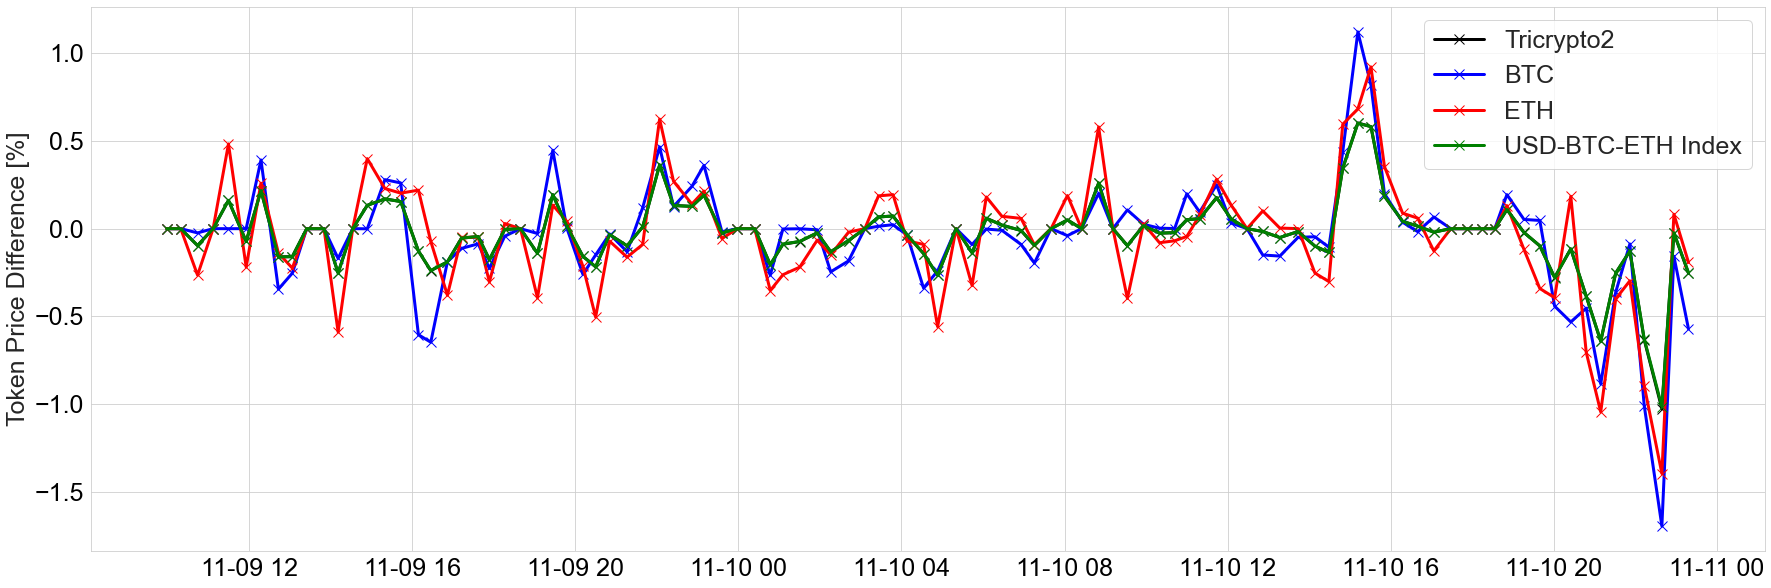

In [57]:
fig, ax = plt.subplots(1,1, figsize=(30, 10))

df_plot = df_prices.where(df_prices['lp_token_price'] > 0)

ax.plot(df_plot.index, df_plot.lp_token_price_diff_perc, 'kx-', lw=3, ms=10, label='Tricrypto2')
ax.plot(df_plot.index, df_plot.btc_price_diff_perc, 'bx-', lw=3, ms=10, label='BTC')
ax.plot(df_plot.index, df_plot.eth_price_diff_perc, 'rx-', lw=3, ms=10, label='ETH')
ax.plot(df_plot.index, df_plot.index_price_diff_perc, 'gx-', lw=3, ms=10, label='USD-BTC-ETH Index')

ax.set_ylabel("Token Price Difference [%]", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.legend(fontsize=25);

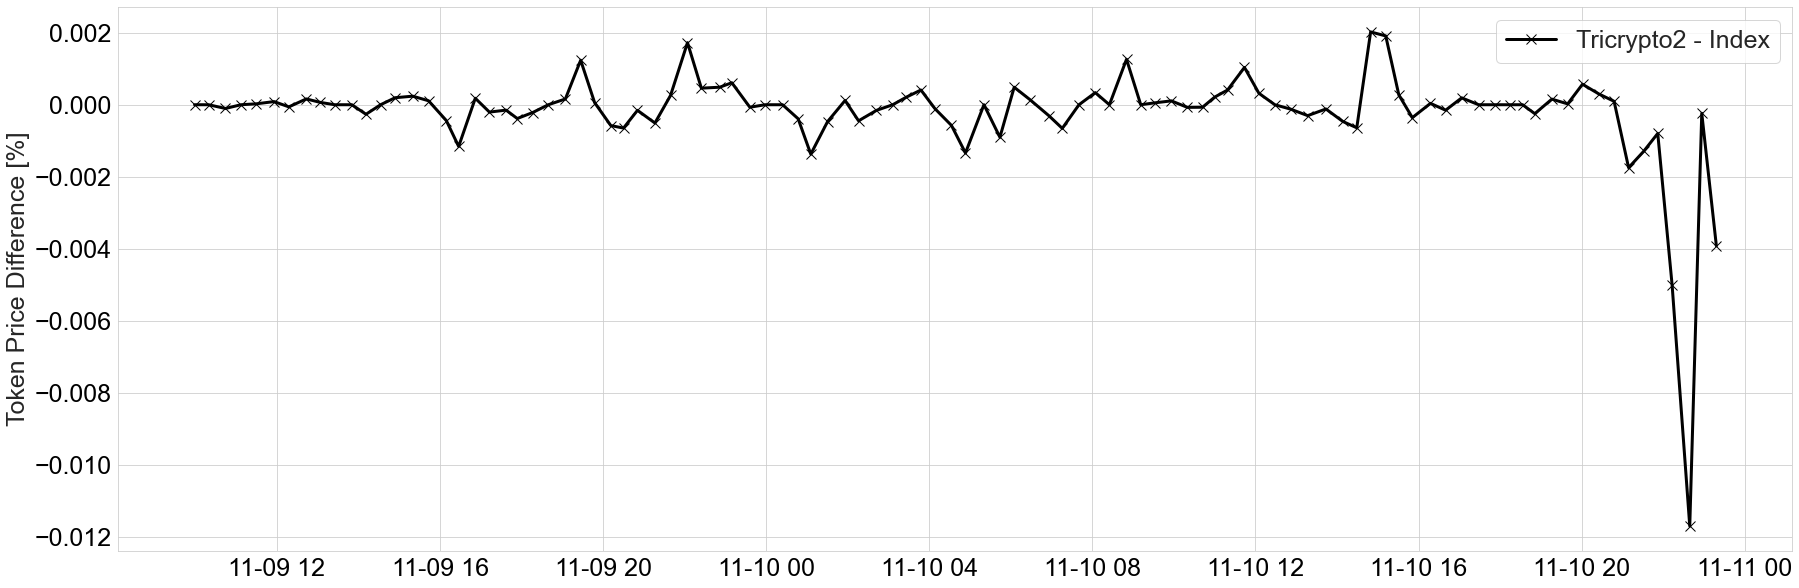

In [63]:
fig, ax = plt.subplots(1,1, figsize=(30, 10))

df_plot = df_prices.where(df_prices['lp_token_price'] > 0)

ax.plot(
    df_plot.index,
    df_plot.lp_token_price_diff_perc - df_plot.index_price_diff_perc,
    'kx-',
    lw=3,
    ms=10,
    label='Tricrypto2 - Index'
)

ax.set_ylabel("Token Price Difference [%]", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.legend(fontsize=25);